<a href="https://colab.research.google.com/github/atharva933/sample-repo/blob/main/notebook/train_yolov12_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [21]:
!nvidia-smi

Fri Jan 16 09:23:54 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [23]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

## Download dataset from Roboflow Universe

In [24]:

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="QEJvR5vBHPHzGYRokaDf")
project = rf.workspace("stevens-institute-of-technology-xjltl").project("shoplifting-detection-oxvwp")
version = project.version(2)
dataset = version.download("yolov8")




loading Roboflow workspace...
loading Roboflow project...


In [25]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [26]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [27]:
!cat {dataset.location}/data.yaml

train: train/images
val: val/images
test: test/images

test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [28]:
!find /content -name data.yaml


/content/Shoplifting-Detection-2/data.yaml


## Evaluate fine-tuned YOLOv12 model

In [ ]:
from ultralytics import YOLO

def train_theft_detection():
    # Load pretrained YOLO model (IMPORTANT)
    model = YOLO("yolov8s.pt")   # pretrained weights = better accuracy

    model.train(
        data="/content/Shoplifting-Detection-2/data.yaml",
        # path to your dataset yaml
        epochs=60,              # more epochs for small dataset
        imgsz=960,               # higher resolution helps action detection
        batch=8,                 # reduce if GPU memory is low
        patience=40,             # early stopping
        lr0=0.001,               # stable learning rate
        optimizer="AdamW",       # better convergence
        workers=8,

        # Augmentations (VERY IMPORTANT for theft detection)
        augment=True,
        mosaic=1.0,
        mixup=0.2,
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.4,
        degrees=5,
        translate=0.1,
        scale=0.5,
        shear=2.0,
        flipud=0.0,
        fliplr=0.5,

        # Regularization
        label_smoothing=0.1,
        weight_decay=0.0005,

        project="/content/runs",     # 🔒 FORCE SAVE LOCATION
        name="shoplift_weights",       # 🔒 FIXED NAME
        exist_ok=True,
        # Validation & Saving
        save=True,
        save_period=10,
        device=0   # change to "cpu" if no GPU
    )

if __name__ == "__main__":
    train_theft_detection()

New https://pypi.org/project/ultralytics/8.4.3 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/Shoplifting-Detection-2/data.yaml, epochs=60, time=None, patience=40, batch=8, imgsz=960, save=True, save_period=10, cache=False, device=0, workers=8, project=/content/runs, name=shoplift_weights, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=F

train: Scanning /content/Shoplifting-Detection-2/train/labels.cache... 6188 images, 17 backgrounds, 0 corrupt: 100%|██████████| 6188/6188 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/Shoplifting-Detection-2/train/images/teenage-girl-shoplifting-in-department-store-model-re-enactment-bob-daemmrich-2B7W4RX_jpg.rf.5cb1554ae2b935d9712979df144928a7.jpg: 1 duplicate labels removed
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 18, len(boxes) = 7465. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Shoplifting-Detection-2/val/labels.cache... 864 images, 2 backgrounds, 0 corrupt: 100%|██████████| 864/864 [00:00<?, ?it/s]


Plotting labels to /content/runs/shoplift_weights/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to /content/runs/shoplift_weights
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      8.11G      1.587      2.194        1.9          8        960: 100%|██████████| 774/774 [04:49<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.42it/s]

                   all        864        952      0.642      0.523      0.561      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.56G      1.465      1.812      1.805         12        960: 100%|██████████| 774/774 [04:41<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.56it/s]

                   all        864        952      0.618      0.498      0.547      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.59G      1.443      1.795      1.793          5        960: 100%|██████████| 774/774 [04:40<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.55it/s]

                   all        864        952      0.696       0.51      0.607      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.57G      1.392      1.719      1.742          8        960: 100%|██████████| 774/774 [04:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.56it/s]

                   all        864        952      0.736      0.546      0.611      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.56G      1.321       1.59      1.679         12        960: 100%|██████████| 774/774 [04:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.56it/s]

                   all        864        952      0.709      0.629      0.681       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.57G      1.269      1.523       1.64          9        960: 100%|██████████| 774/774 [04:40<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:14<00:00,  3.61it/s]

                   all        864        952      0.779      0.614      0.695      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.57G        1.2       1.41      1.578          6        960: 100%|██████████| 774/774 [04:34<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.43it/s]

                   all        864        952      0.809      0.671      0.731      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      4.59G      1.174      1.346      1.561         11        960: 100%|██████████| 774/774 [04:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.58it/s]

                   all        864        952      0.844      0.689      0.745      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.44it/s]

                   all        864        952      0.796      0.705       0.75      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.57G      1.118      1.263      1.518         33        960:  92%|█████████▏| 710/774 [04:13<00:24,  2.66it/s]

In [34]:
!mv /content/Shoplifting-Detection-2/valid /content/Shoplifting-Detection-2/val


In [35]:
!ls /content/Shoplifting-Detection-2


data.yaml  README.dataset.txt  README.roboflow.txt  test  train  val


In [36]:
!ls /content/Shoplifting-Detection-2/val

images	labels


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch1.jpg
confusion_matrix_normalized.png			   train_batch2.jpg
confusion_matrix.png				   train_batch3330.jpg
events.out.tfevents.1767712706.e14a86c1f128.419.0  train_batch3331.jpg
F1_curve.png					   train_batch3332.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


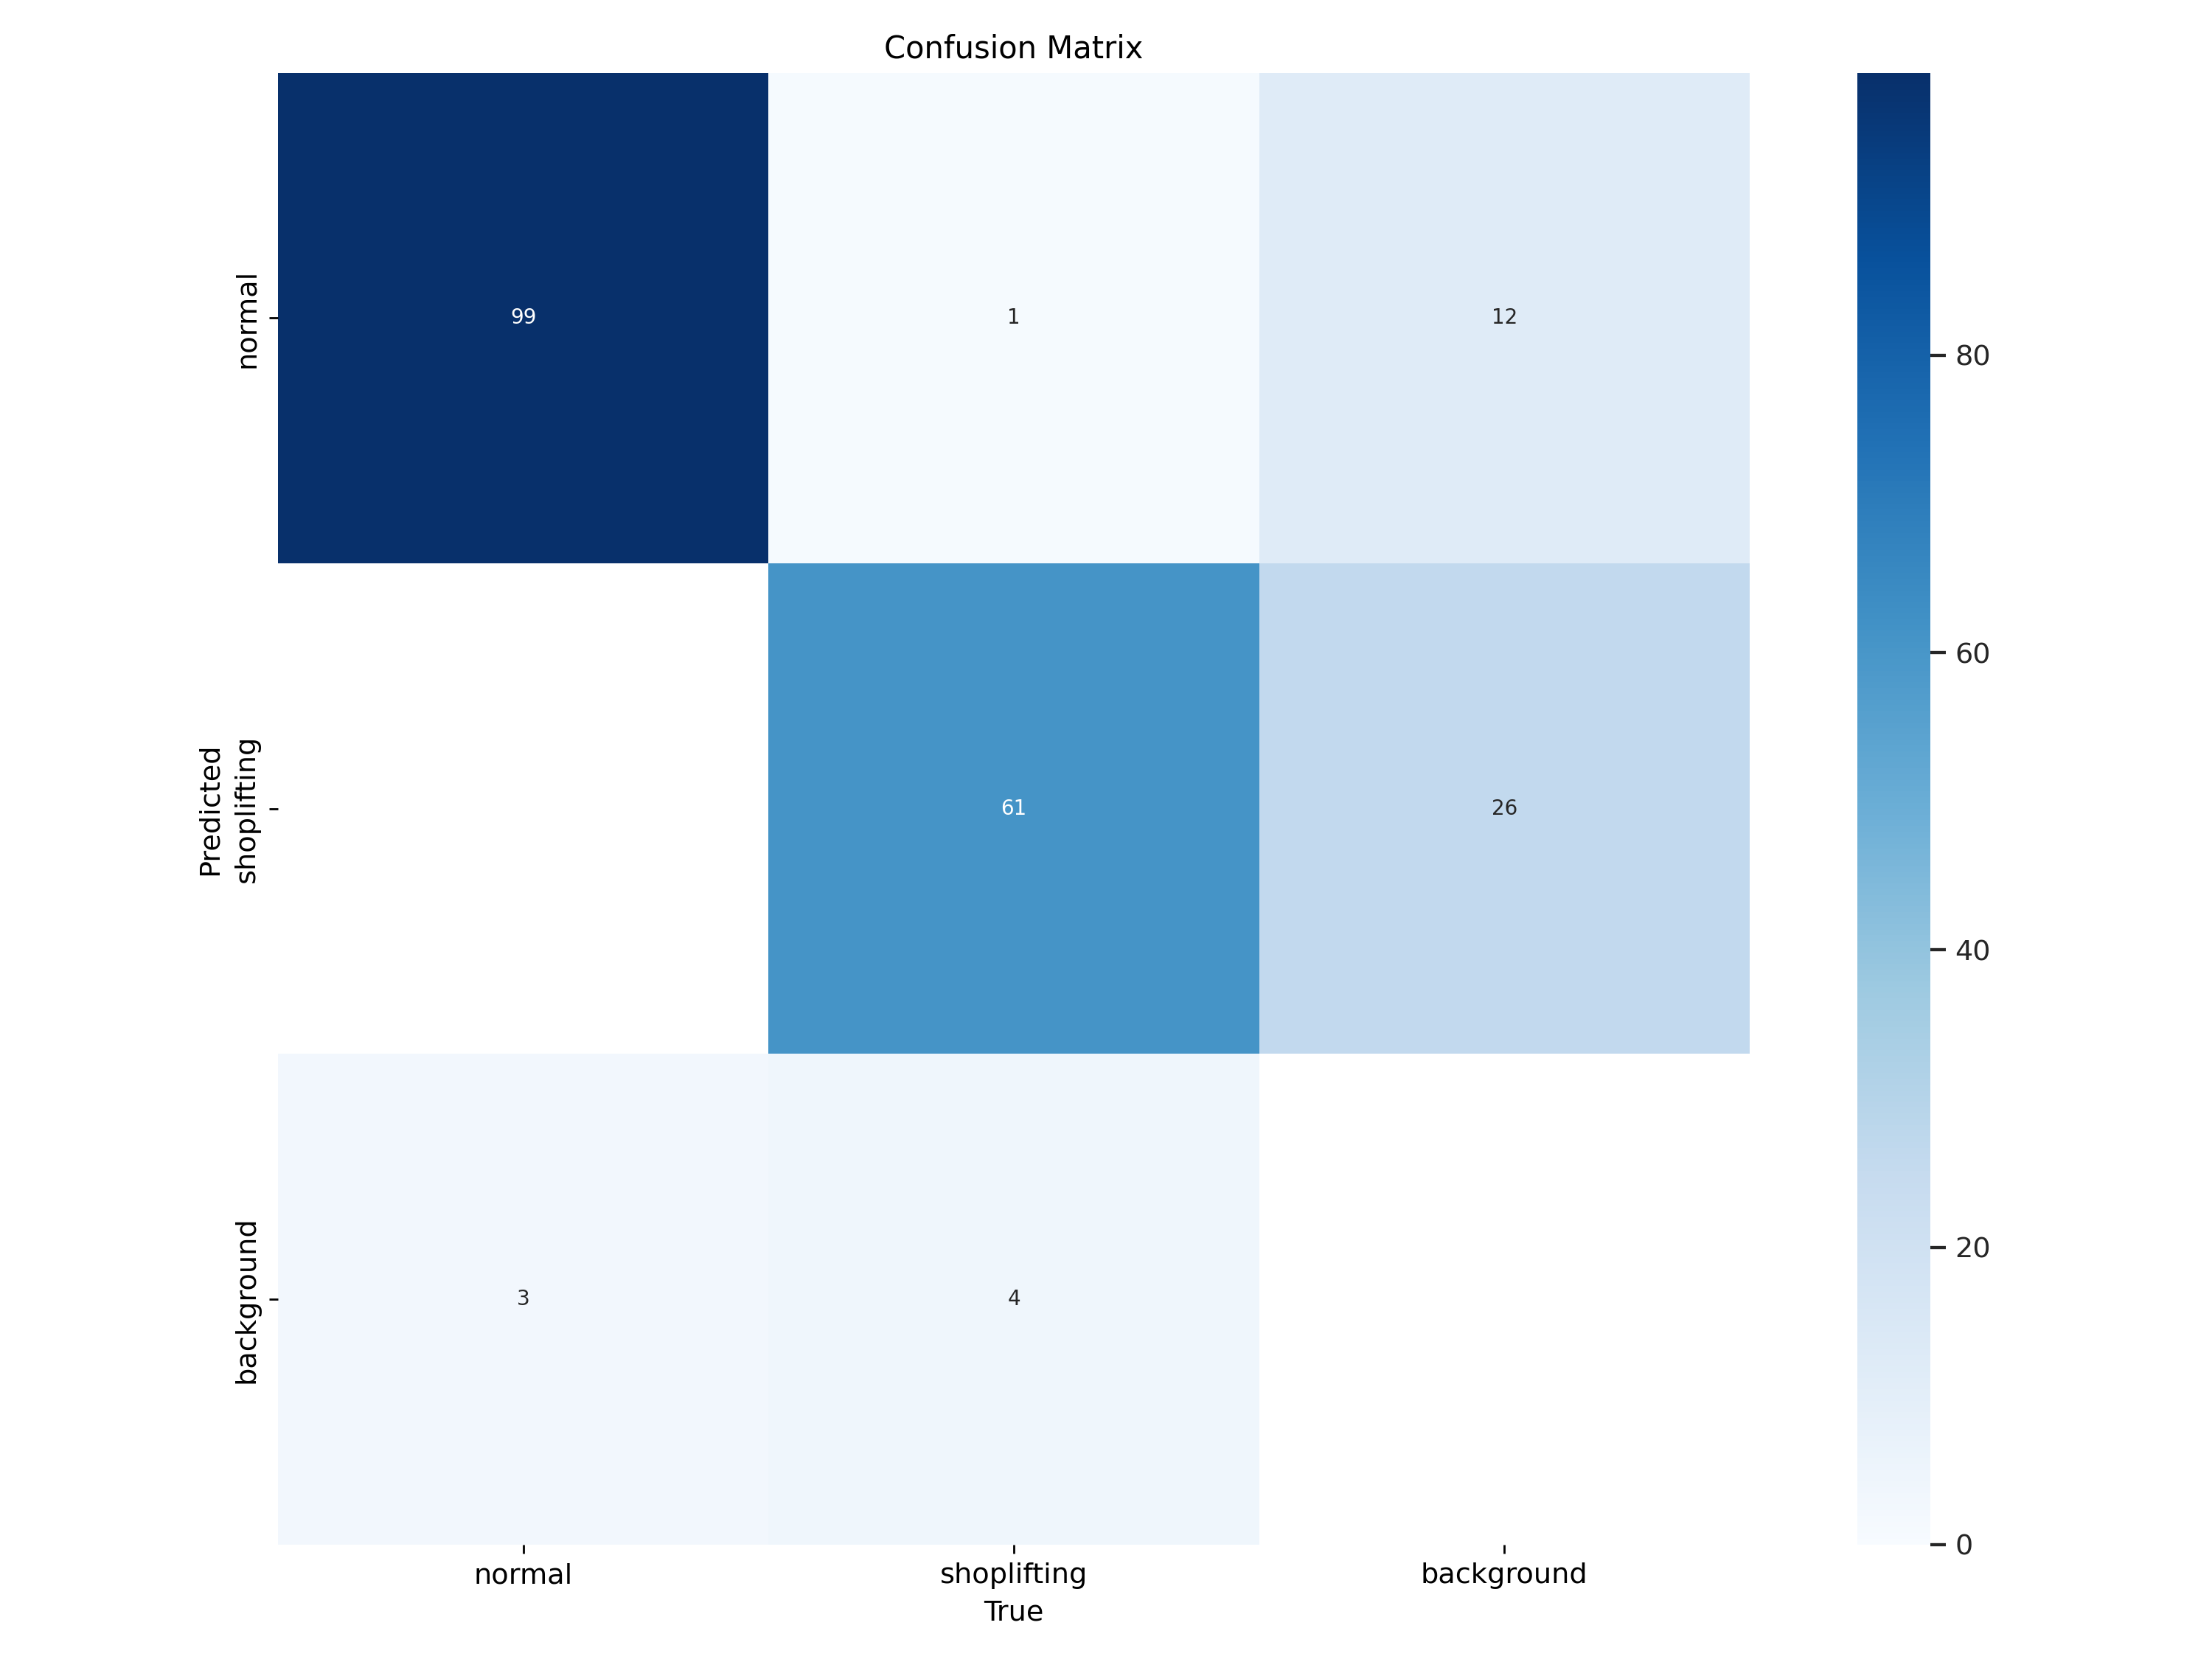

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

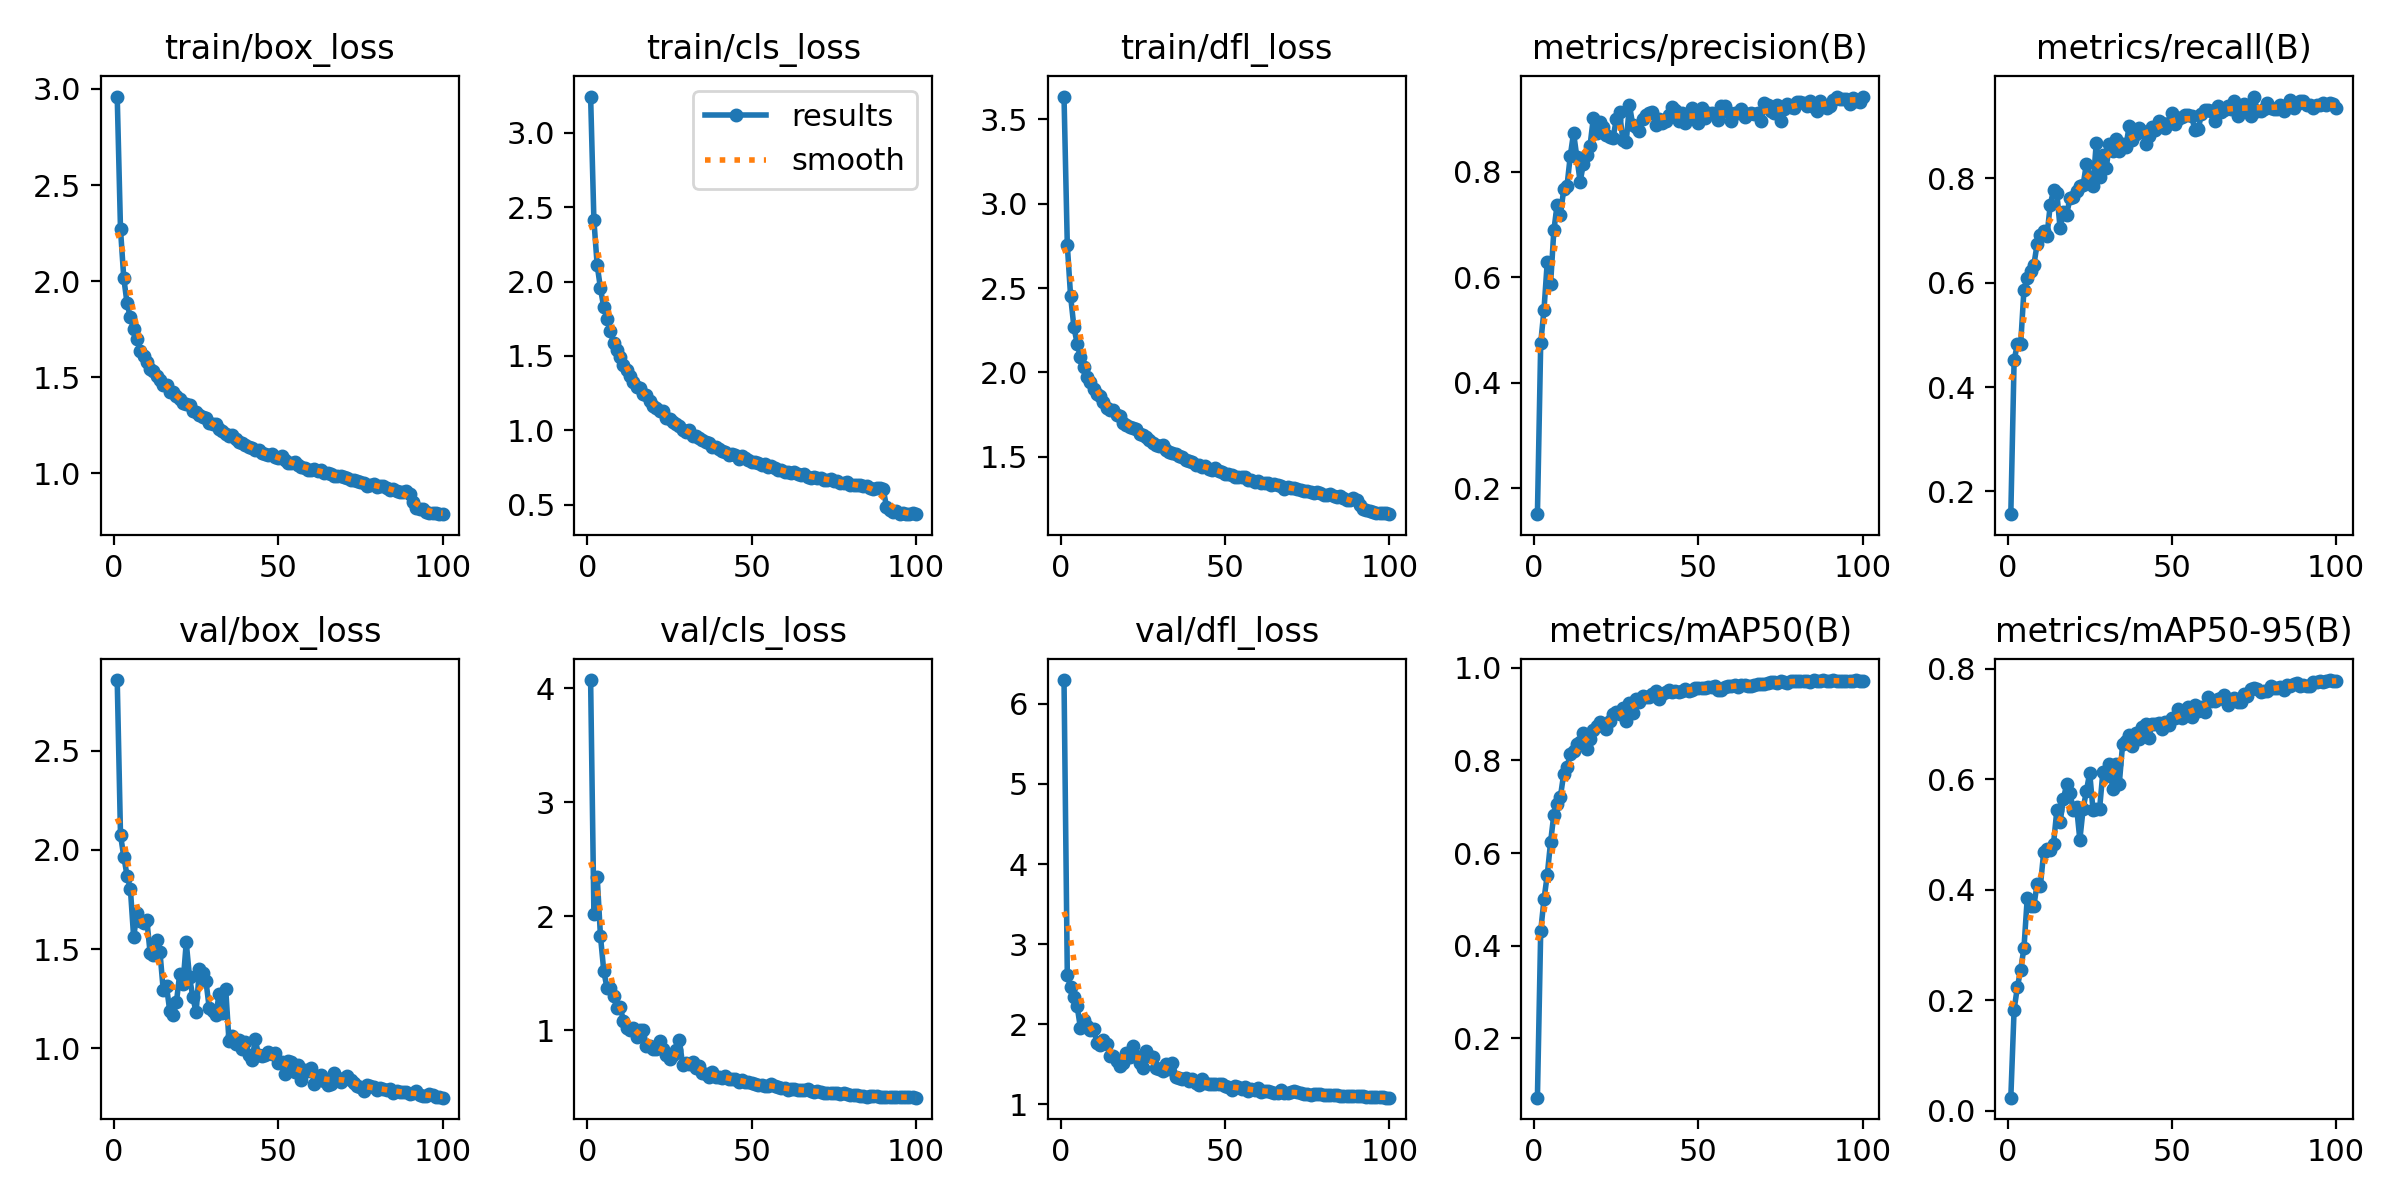

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['normal', 'shoplifting']

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.8807832111364464
mAP 50 0.9534907591468864
mAP 75 0.9504998350544772


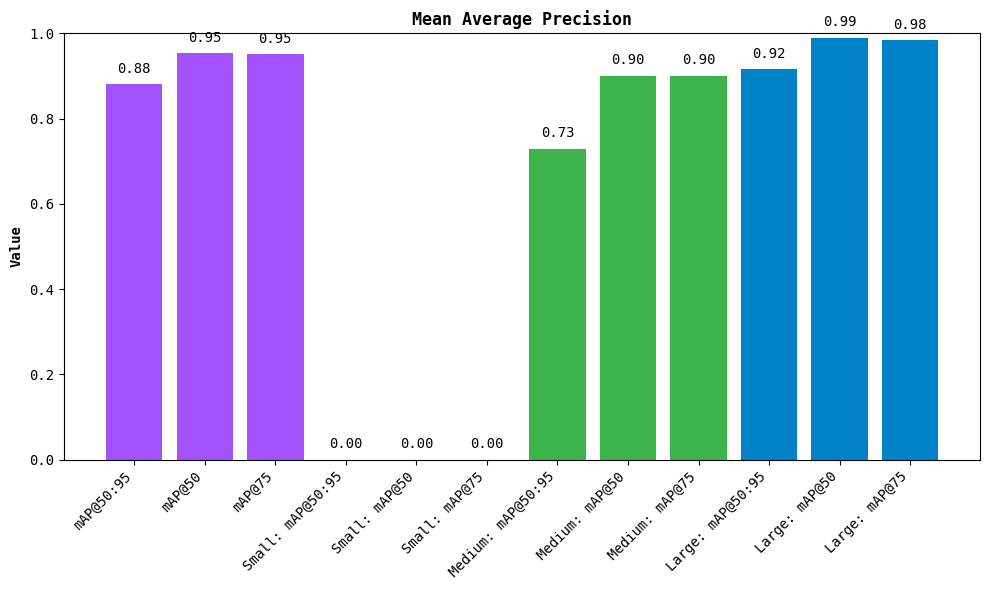

In [ ]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [ ]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

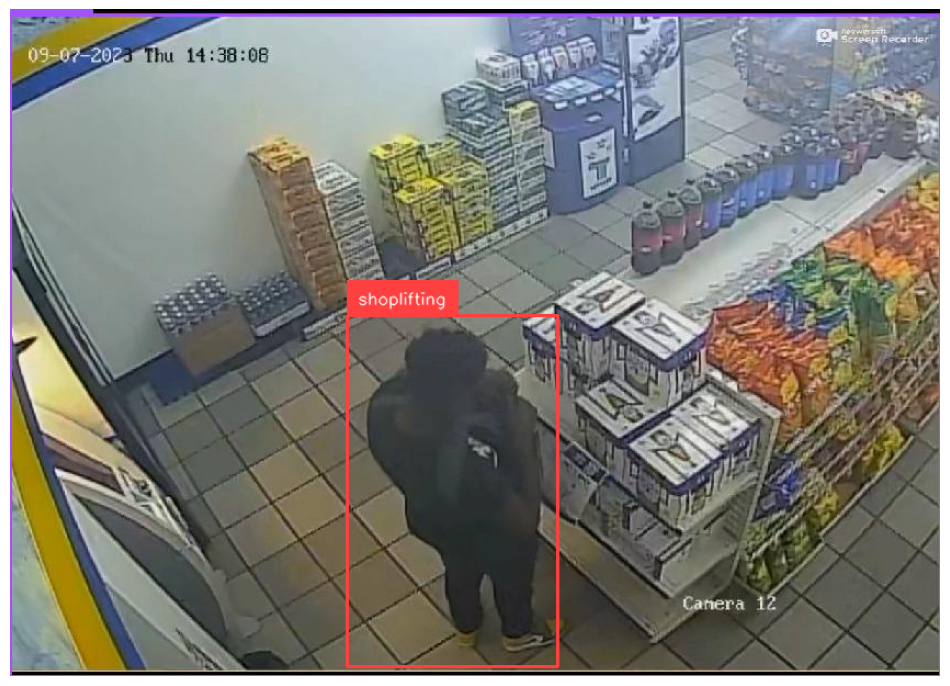

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [12]:
!ls -la /content

total 20
drwxr-xr-x 1 root root 4096 Jan 13 08:47 .
drwxr-xr-x 1 root root 4096 Jan 13 08:40 ..
drwxr-xr-x 4 root root 4096 Dec 11 14:34 .config
drwxr-xr-x 5 root root 4096 Jan 13 08:47 FYP-Shoplift-1
drwxr-xr-x 1 root root 4096 Dec 11 14:34 sample_data


In [13]:
!find /content -type f -name best.pt

In [16]:
from google.colab import files
files.download("/root/.config/yolov12/runs/detect/train2/weights/best.pt")


FileNotFoundError: Cannot find file: /root/.config/yolov12/runs/detect/train2/weights/best.pt

In [15]:
!find /root -name best.pt

In [18]:
from ultralytics import settings
print(settings)


ModuleNotFoundError: No module named 'ultralytics'